# Descripción del Ejercicio 
Has recibido una tarea analítica de una tienda en línea internacional. Tus predecesores no consiguieron completarla: lanzaron una prueba A/B y luego abandonaron (para iniciar una granja de sandías en Brasil). Solo dejaron las especificaciones técnicas y los resultados de las pruebas.

# Descripción Técnica 
- Nombre de la prueba: `recommender_system_test`
- Grupos: А (control), B (nuevo embudo de pago)
- Launch date: 2020-12-07
- Fecha en la que dejaron de aceptar nuevos usuarios: 2020-12-21
- Fecha de finalización: 2021-01-01
- Audiencia: 15% de los nuevos usuarios de la región de la UE
- Propósito de la prueba: probar cambios relacionados con la introducción de un sistema de recomendaciones mejorado
- Resultado esperado: dentro de los 14 días posteriores a la inscripción, los usuarios mostrarán una mejor conversión en vistas de la página del producto (el evento `product_page`), instancias de agregar artículos al carrito de compras (`product_card`) y compras (`purchase`). En cada etapa del embudo `product_page → product_card → purchase`, habrá al menos un 10% de aumento.
- Número previsto de participantes de la prueba: 6 000


# Instrucciones a seguir 
- Describe los objetivos del estudio.
- Explora los datos:
    - ¿Es necesario convertir los tipos?
    - ¿Hay valores ausentes o duplicados? Si es así, ¿cómo los caracterizarías?
- Lleva a cabo el análisis exploratorio de datos:
    - Estudia la conversión en las diferentes etapas del embudo.
    - ¿El número de eventos por usuario está distribuido equitativamente entre las muestras?
    - ¿Hay usuarios que están presentes en ambas muestras?
    - ¿Cómo se distribuye el número de eventos entre los días?
    - ¿Hay alguna peculiaridad en los datos que hay que tener en cuenta antes de iniciar la prueba A/B?
- Evaluar los resultados de la prueba A/B:
    - ¿Qué puedes decir sobre los resultados de la prueba A/B?
    - Utiliza una prueba z para comprobar la diferencia estadística entre las proporciones
- Describe tus conclusiones con respecto a la etapa EDA y los resultados de la prueba A/B

# Importar Librerías 


In [95]:
# Librerías para la manipulación de datosm
import pandas as pd 
import numpy as np 
import math 
import datetime as dt 
# Librerías para el estudio estadístico 
from scipy import stats as st 
# Librerías para la visualización de datos  
import seaborn as sns 
import matplotlib.pyplot as plt 

# Importar datasets 

In [96]:
# Calendario de eventos de marketing 
marketing_events = pd.read_csv('ab_project_marketing_events_us.csv')
# Usuarios que se registraron 
users = pd.read_csv('final_ab_new_users_upd_us.csv')
# Evento de los usuarios 
events = pd.read_csv('final_ab_events_upd_us.csv')
# Datos de los participantes de la prueba 
user_data = pd.read_csv('final_ab_participants_upd_us.csv')

# Descripción de los datos 
- `marketing_events`: el calendario de eventos de marketing para 2020
- `users`: todos los usuarios que se registraron en la tienda en línea desde el 7 hasta el 21 de diciembre de 2020
- `events`: todos los eventos de los nuevos usuarios en el período comprendido entre el 7 de diciembre de 2020 y el 1 de enero de 2021
- `user_data`: tabla con los datos de los participantes de la prueba

## Marketing Events 
- `name`: el nombre del evento de marketing
- `regions`: regiones donde se llevará a cabo la campaña publicitaria
- `start_dt`: fecha de inicio de la campaña
- `finish_dt`: fecha de finalización de la campaña

In [97]:
marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


## Users
- `user_id`
- `first_date`: fecha de inscripción
- `region`
- `device`: dispositivo utilizado para la inscripción

In [98]:
users.head(10)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
5,137119F5A9E69421,2020-12-07,N.America,iPhone
6,62F0C741CC42D0CC,2020-12-07,APAC,iPhone
7,8942E64218C9A1ED,2020-12-07,EU,PC
8,499AFACF904BBAE3,2020-12-07,N.America,iPhone
9,FFCEA1179C253104,2020-12-07,EU,Android


## Events 
- `user_id`
- `event_dt`: fecha y hora del evento
- `event_name`: nombre del tipo de evento
- `details`: datos adicionales sobre el evento (por ejemplo, el pedido total en USD para los eventos `purchase`)

In [99]:
events.head(10)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99
6,6B2F726BFD5F8220,2020-12-07 11:27:42,purchase,4.99
7,BEB37715AACF53B0,2020-12-07 04:26:15,purchase,4.99
8,B5FA27F582227197,2020-12-07 01:46:37,purchase,4.99
9,A92195E3CFB83DBD,2020-12-07 00:32:07,purchase,4.99


## User Data 
- `user_id`
- `ab_test`: nombre de la prueba
- `group`: el grupo de prueba al que pertenecía el usuario

In [100]:
user_data.head(10)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test
5,7473E0943673C09E,A,recommender_system_test
6,C46FE336D240A054,A,recommender_system_test
7,92CB588012C10D3D,A,recommender_system_test
8,B3A2485649E4A012,A,recommender_system_test
9,66FC298441D50783,A,recommender_system_test


# Preprocesamiento de Datos 

## Valores Ausentes 

### Marketing Events 


In [101]:
marketing_events.isna().sum()

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

El dataset no muestra ningún valor ausente 

### Users 

In [102]:
users.isna().sum()

user_id       0
first_date    0
region        0
device        0
dtype: int64

El dataset no muestra ningún valor ausente 

### Events 


In [103]:
events.isna().sum()

user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64

El dataset muestra una gran cantidad de valores ausentes en la columna `details`, sin embargo estos datos solamente dan información adicional para los diferentes eventos del dataset y el eliminarlos nos haría perder información muy importante para el estudio del embudo, por lo que no se eliminarán 

### User Data


In [104]:
user_data.isna().sum()

user_id    0
group      0
ab_test    0
dtype: int64

El dataset no muestra ningún valor ausente 

## ¿Es necesario convertir los datos?


Utilizar la información general de los datasets para ver el tipo de datos actuales y tomar decisiones en base a el

### Marketing Events


In [105]:
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 580.0+ bytes


Las columnas referentes a las fechas de inicio y final deberían ser tipo datetime, pero son de tipo object y por esa razón se pasarán a tipo datetime

In [106]:
# Convertir a tipo datetime
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])

### Users

In [107]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [108]:
# Convertir a tipo datetime 
users['first_date'] = pd.to_datetime(users['first_date'])

### Events 

In [109]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB


In [110]:
# Convertir a tipo datetime 
events['event_dt'] = pd.to_datetime(events['event_dt'])

### User Data 

In [111]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


## Valores Duplicados 



### Marketing Events 


In [112]:
marketing_events.duplicated().sum()

0

### Users 

In [113]:
users.duplicated().sum()

0

### Events 

In [114]:
events.duplicated().sum()

0

### User Data 


In [115]:
user_data.duplicated().sum()

0

# Análisis Exploratorio de Datos 

## Conversión en las diferentes etapas del embudo 

In [116]:

r = user_data.groupby('user_id')['group'].nunique().sort_values(ascending=False)

In [117]:
events.columns

Index(['user_id', 'event_dt', 'event_name', 'details'], dtype='object')

In [118]:

events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

In [119]:
user_per_event = events.groupby('event_name', as_index=False)['user_id'].nunique().sort_values(by='user_id',ascending=False)

In [120]:
user_per_event

,event_name,user_id
0,login,58696
2,product_page,38929
3,purchase,19568
1,product_cart,19284


In [121]:
login_to_product =  (int(user_per_event['user_id'][user_per_event['event_name']=='product_page']) / int(user_per_event['user_id'][user_per_event['event_name']=='login']))*100
product_to_cart = (int(user_per_event['user_id'][user_per_event['event_name']=='product_cart']) / int(user_per_event['user_id'][user_per_event['event_name']=='product_page']))*100
cart_to_purchase = (int(user_per_event['user_id'][user_per_event['event_name']=='purchase']) / int(user_per_event['user_id'][user_per_event['event_name']=='product_cart']))*100

C:\Users\User\AppData\Local\Temp\ipykernel_16284\2712483597.py:1: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  login_to_product =  (int(user_per_event['user_id'][user_per_event['event_name']=='product_page']) / int(user_per_event['user_id'][user_per_event['event_name']=='login']))*100
C:\Users\User\AppData\Local\Temp\ipykernel_16284\2712483597.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  product_to_cart = (int(user_per_event['user_id'][user_per_event['event_name']=='product_cart']) / int(user_per_event['user_id'][user_per_event['event_name']=='product_page']))*100
C:\Users\User\AppData\Local\Temp\ipykernel_16284\2712483597.py:3: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cart_to_purchase = (int(

In [122]:
login_to_product, product_to_cart, cart_to_purchase

(66.32308845577212, 49.53633537979398, 101.47272350134826)

In [123]:
r = user_data.groupby('user_id',as_index=False)['group'].nunique().sort_values(by='group',ascending=False)

In [124]:
r['user_id'][r['group']==2]

9416     B06B45B7C3E5E721
12224    E594B711ADD81DD8
9004     A8C25A605F613665
3070     3A6D88AB973BD99D
564      0ADFFFE9C0D60092
               ...       
9940     BAAEE6D68FB90D22
3585     4409E20FCD07CD14
10284    C1E43A9B1D675927
11586    D9C92EC5F9478381
7044     83E9CFC64D61108E
Name: user_id, Length: 441, dtype: object

In [125]:
user_data.isna().sum()

user_id    0
group      0
ab_test    0
dtype: int64

In [136]:
group_A = user_data[user_data['group']=='A']
group_B = user_data[user_data['group']=='B']

In [138]:
user_data['group'].value_counts()

group
A    8214
B    6311
Name: count, dtype: int64

In [141]:
user_data['user_id'].nunique()

13638

In [142]:
events['user_id'].nunique()

58703

In [127]:
group_A

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test
...,...,...,...
14516,96304D5B53694096,A,interface_eu_test
14518,A1281767A2983E4D,A,interface_eu_test
14521,3DE51B726983B657,A,interface_eu_test
14522,F501F79D332BE86C,A,interface_eu_test


In [128]:
event_per_user = events.groupby('user_id')['event_name'].nunique().sort_values(ascending=False).reset_index()

In [135]:
event_per_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   event_name  58703 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 917.4+ KB


In [133]:
data_A = pd.merge(group_A,event_per_user,left_on='user_id',right_on='user_id')

In [134]:
data_A

,user_id,group,ab_test,event_name
0,D1ABA3E2887B6A73,A,recommender_system_test,4
1,A7A3664BD6242119,A,recommender_system_test,2
2,DABC14FDDFADD29E,A,recommender_system_test,1
3,04988C5DF189632E,A,recommender_system_test,3
4,4FF2998A348C484F,A,recommender_system_test,4
...,...,...,...,...
8209,96304D5B53694096,A,interface_eu_test,3
8210,A1281767A2983E4D,A,interface_eu_test,3
8211,3DE51B726983B657,A,interface_eu_test,4
8212,F501F79D332BE86C,A,interface_eu_test,2


In [147]:
events['date'] = pd.to_datetime(events['event_dt'].dt.date)

In [151]:
t = events.groupby('date', as_index=False)['event_name'].count()

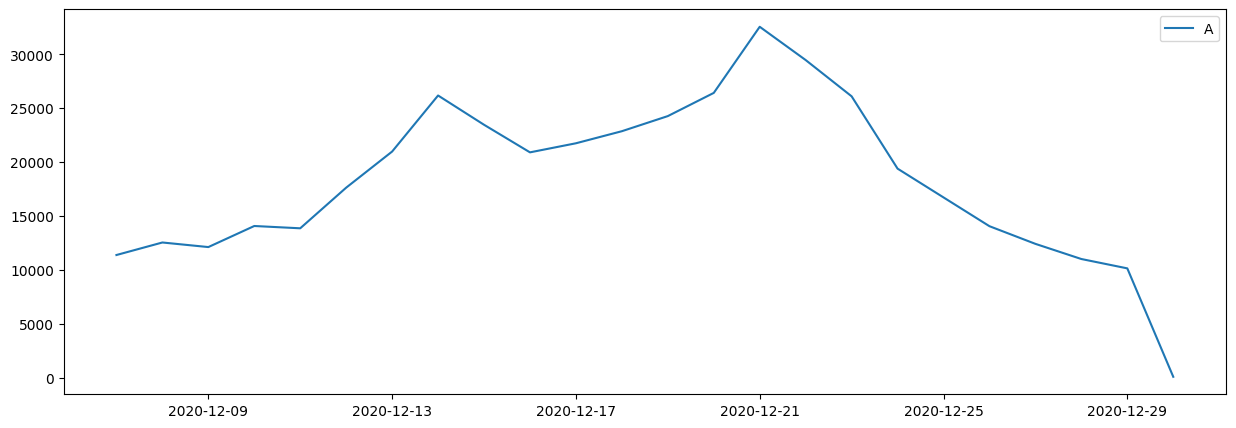

In [162]:
plt.figure(figsize=(15,5))
plt.plot(t['date'],t['event_name'], label='A')
plt.legend()